# Visualising Ocean Bottom Age Using the Ideal Age Tracer

This notebook demonstrates how to plot **ocean Ideal Age**, a tracer that is reset to zero at the surface each timestep and increases by one year per model year below the surface.  
Although not a direct analogue, Ideal Age acts as a useful **proxy for water-mass ventilation and nutrient distribution** (e.g., carbon or oxygen).

By mapping the Ideal Age in the **deepest valid ocean layer**, we can highlight the pathways of the densest, oldest water masses.  
The workflow uses Iris to extract the bottommost values from a 3-D field and visualise them on a global map.

In [1]:
import iris
import cftime
from dask.distributed import Client

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45615,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39757,Total threads: 1
Dashboard: /proxy/38005/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:38905,


In [3]:
from esmvalcore.dataset import Dataset

model_OM2 = Dataset(short_name='agessc', project='CMIP6',
    activity='OMIP', mip="Omon", exp="omip2",
    ensemble="r1i1p1f1", timerange="*",
    dataset="ACCESS-OM2", grid="gn")

age = model_OM2.load()

###
# Print the time range so we can decide on a year:
# Extract time coordinates
time_coord = age.coord('time')

# Convert to datetime objects
dates = time_coord.units.num2date(time_coord.points)

# Get start and end dates
print("Start:", dates.min())
print("End:", dates.max())

Start: 0001-01-16 12:00:00
End: 0366-12-16 12:00:00


In [4]:
from esmvalcore.preprocessor import extract_time

selected_year = extract_time(age, start_year=365, start_month=1, start_day=1, end_month=1, end_day=1,  end_year=366)

In [5]:
from esmvalcore.preprocessor import climate_statistics

selected_year_mean = climate_statistics(age, period='full', operator='mean')

## Extracting the Bottom Value

For each vertical column, we identify the **deepest valid (non-NaN)** data point.  
The `bottom_nonan` aggregator:

1. Masks invalid (`NaN` or infinite) values.  
2. Scans upward from the bottom to find the last valid entry.  
3. Extracts that value for each horizontal grid cell.  
4. Masks columns with no valid data.

This produces a 2-D field representing the value at the ocean floor for every location.

In [10]:
"""
Preprocessor to extract the deepest non-NaN (bottom) value along a vertical axis.
"""

import iris
import numpy as np


def _bottom_nonan(values, axis):
    """Return the deepest non-NaN value along `axis`."""
    data = np.ma.masked_invalid(values)
    valid = ~data.mask
    depth_len = data.shape[axis]

    # Reverse along depth to find first valid from bottom
    rev_valid = np.flip(valid, axis=axis)
    idx_from_bottom = rev_valid.argmax(axis=axis)

    # Convert back to original index
    bottom_idx = depth_len - 1 - idx_from_bottom

    # Move depth axis to front for easier indexing
    data_moved = np.moveaxis(data, axis, 0)
    expanded_idx = bottom_idx[None, ...]
    bottom = np.take_along_axis(data_moved, expanded_idx, axis=0)[0]

    # Mask columns that are fully invalid
    has_valid = valid.any(axis=axis)
    bottom_mask = ~has_valid
    bottom = np.ma.array(bottom, mask=bottom_mask)
    return bottom


def _find_depth_coord(cube):
    """Try to identify the vertical coordinate in a cube."""
    for coord in cube.coords(dim_coords=True):
        name = coord.name().lower()
        std = (coord.standard_name or "").lower()
        var = (coord.var_name or "").lower()
        if any(key in (name, std, var) for key in ["depth", "z", "lev", "level"]):
            return coord.name()
    raise ValueError("No vertical (depth/level/z) coordinate found in cube.")


def extract_bottom(cube, depth_coord=None):
    """
    Extract the deepest valid (non-NaN) value from a 3-D field.

    Parameters
    ----------
    cube : iris.cube.Cube
        Input 3D cube with a vertical (depth) coordinate.
    depth_coord : str, optional
        Name of the depth coordinate. If None, it will be inferred.

    Returns
    -------
    iris.cube.Cube
        2D cube representing the bottom value at each horizontal location.
    """
    if depth_coord is None:
        depth_coord = _find_depth_coord(cube)

    bottom_aggregator = iris.analysis.Aggregator(
        'bottom_nonan',
        _bottom_nonan,
        units_func=lambda units: units,
    )

    bottom_cube = cube.collapsed(depth_coord, bottom_aggregator)
    bottom_cube.rename(f"{cube.name()}_bottom")

    return bottom_cube


In [11]:
bottom_cube = extract_bottom(selected_year_mean)

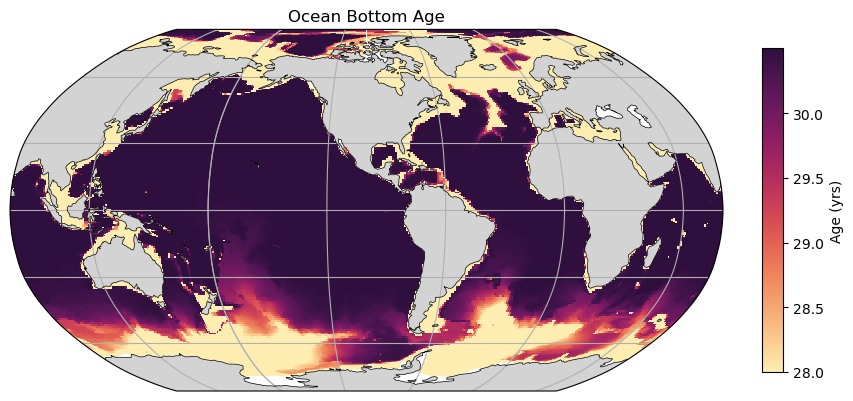

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cm
import iris.plot as iplt
import cartopy.feature as cfeature

# --- Figure and map setup ---
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
ax.set_global()
ax.gridlines(draw_labels=False)

# --- Extract 2D coordinate arrays ---
lon = bottom_cube.coord('longitude').points
lat = bottom_cube.coord('latitude').points

# --- Plot bottom age ---
bottom_plot = plt.pcolormesh(
    lon, lat, bottom_cube.data,
    cmap=cm.matter,
    vmin=28,
    transform=ccrs.PlateCarree(),
)

# --- Add land and coastlines ---
ax.add_feature(cfeature.LAND, facecolor='lightgrey', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=3)

# --- Add colourbar ---
plt.colorbar(
    bottom_plot,
    ax=ax,
    label='Age (yrs)',
    fraction=0.03,
    aspect=15,
    shrink=0.7
)

plt.title('Ocean Bottom Age')
plt.show()


### Notes and Conclusions

- **Young water on continental shelves:**  
  Shallow regions appear young because surface resetting dominates in areas with limited depth.

- **North Atlantic renewal:**  
  The North Atlantic displays relatively young ages due to the formation and southward export of **North Atlantic Deep Water (NADW)**.  
  Both the **Deep Western Boundary Current** and the **Mid-Atlantic Ridge** help channel this newly formed deep water toward the south.

- **Southern Ocean influence:**  
  The spread of **Antarctic Bottom Water (AABW)** is visible as slightly younger layers along western boundaries in each basin, gradually mixing with older waters above.

- **Old water in the North Pacific:**  
  The **northeastern Pacific** stands out as one of the oldest regions, reflecting extremely weak deep-water ventilation and long isolation from surface contact — even within the model’s simulation period.
